# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Преоставлены исторические данные: технические характеристики, комплектации и цены автомобилей. Требуется построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

<b>Признаки:</b>
<ul>
<li>DateCrawled — дата скачивания анкеты из базы</li>
<li>VehicleType — тип автомобильного кузова</li>
<li>RegistrationYear — год регистрации автомобиля</li>
<li>Gearbox — тип коробки передач</li>
<li>Power — мощность (л. с.)</li>
<li>Model — модель автомобиля</li>
<li>Kilometer — пробег (км)</li>
<li>RegistrationMonth — месяц регистрации автомобиля</li>
<li>FuelType — тип топлива</li>
<li>Brand — марка автомобиля</li>
<li>NotRepaired — была машина в ремонте или нет</li>
<li>DateCreated — дата создания анкеты</li>
<li>NumberOfPictures — количество фотографий автомобиля</li>
<li>PostalCode — почтовый индекс владельца анкеты (пользователя)</li>
<li>LastSeen — дата последней активности пользователя</li>
</ul>
<b>Целевой признак:</b>
<ul>
<li>Price — цена (евро)</li>
</ul>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

## Подготовка данных

### Первичный осмотр данных

In [4]:
data = pd.read_csv('autos.csv')

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [8]:
np.sort(data['RegistrationYear'].unique())

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

In [9]:
np.sort(data['Power'].unique())

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

In [10]:
data.duplicated().sum()

4

In [11]:
data.isna().mean().sort_values()

DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
Model                0.055606
Gearbox              0.055967
FuelType             0.092827
VehicleType          0.105794
NotRepaired          0.200791
dtype: float64

Можно заметить, что присутствуют аномально большие значения для года регистрации автомобиля, а также для можности (20000). Самый мощный автомобиль, найденный мной имеет мощность 757 л.с.. Также в данных прусутствуют дубликаты, а в некоторых столбцах и пропуски. Также следует заменить формат даты

### Предобработка данных

#### Изменение формата даты

In [12]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

#### Избавление от дубликатов

In [13]:
data = data.drop_duplicates().reset_index(drop = True)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  NotRepaired        283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

#### Избавление от пропусков

Пропуски присутствуют в 5 столбцах: Model - модель автомобиля, Gearbox - тип коробки передач, FuelType - тип топлива, VehicleType - тип автомобильного кузова, NotRepaired - была машина в ремонте или нет

<b>Столбец NotRepaired</b>

Заполним пропущенные значения значением "no", так как, по моему мнению, если значение в данном столбце не указано, то машина не находилась в ремонте

In [15]:
data['NotRepaired'] = data['NotRepaired'].fillna('no')

По остальным столбцам мы не сможем узнать, какие значение пропущены, не спросив у того, кто предоставляет данный датасет, поэтому заполним оставшиеся пропуски слово unknown

In [16]:
data = data.fillna('unknown')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        354365 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            354365 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              354365 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           354365 non-null  object        
 10  Brand              354365 non-null  object        
 11  NotRepaired        354365 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

#### Избавление от аномальных значений

Требуется избавится от аномальных значений в столбцах RegistrationYear и Power

<b>Столбец RegistrationYear</b>

In [17]:
cars_count = data.groupby('RegistrationYear')['Brand'].count()
display(cars_count)
pd.set_option('display.max_rows', 1000)

RegistrationYear
1000    37
1001     1
1039     1
1111     3
1200     1
        ..
9000     3
9229     1
9450     1
9996     1
9999    26
Name: Brand, Length: 151, dtype: int64

Здесь можно заметить, что очень мало значений до 1960 года, также удалим значения после 2019

Text(0, 0.5, 'количество машин')

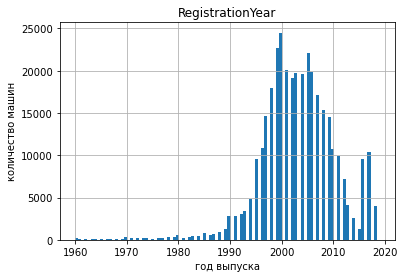

In [18]:
data = data.query('1960 <=RegistrationYear <= 2019').reset_index(drop = True)
data.hist('RegistrationYear', bins = 100)
plt.xlabel('год выпуска')
plt.ylabel('количество машин')

<b>Столбец Power</b>

In [19]:
cars_count_power = data.groupby('Power')['Brand'].count()
display(cars_count_power)
pd.set_option('display.max_rows', 1000)

Power
0        39903
1           33
2           10
3            8
4           30
5          102
6           11
7           11
8            6
9            4
10          14
11          27
12          19
13           7
14          20
15          18
16           9
17           8
18          48
19          12
20          20
21           5
22           4
23          38
24          26
25          15
26         287
27          38
28           5
29          35
30          24
31           9
32           4
33          58
34         183
35          10
36           8
37          48
38          14
39         138
40         315
41         441
42          49
43         115
44         393
45        2977
46          57
47          33
48          93
49          24
50        4622
51          93
52         317
53         208
54        5741
55        2109
56         273
57         129
58        3851
59         248
60       15891
61         989
62          96
63         402
64        1568
65        2189
66  

Можно заметить много значений около нуля, что говорит о том, что владельцы автомобилей не знают мощность воей машины, данные знаения нецелесообразно удалять, так как мы потеряем много данных, а вот значения после 400 л.с. стоит удалить

Text(0, 0.5, 'количество машин')

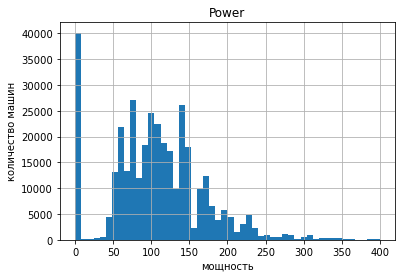

In [20]:
data = data.query('0 <= Power <= 400').reset_index(drop = True)
data.hist('Power', bins = 50)
plt.xlabel('мощность')
plt.ylabel('количество машин')

#### Кодировка категориальных колонок

В столбцах VehicleType, Gearbox, FuelType, Brand и Model будем кодировать категориальные колонки с помощью прямого кодирования.

In [21]:
new_data = pd.concat([data, pd.get_dummies(data[['VehicleType', 'Gearbox', 'FuelType', 'Brand']])], axis = 1)
new_data = new_data.drop(columns = ['VehicleType', 'Gearbox', 'FuelType', 'Brand'])

new_data.head()

,DateCrawled,Price,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,NotRepaired,DateCreated,NumberOfPictures,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
0,2016-03-24 11:52:17,480,1993,0,golf,150000,0,no,2016-03-24 11:52:17,0,...,0,0,0,0,0,0,0,0,1,0
1,2016-03-24 10:58:45,18300,2011,190,unknown,125000,5,yes,2016-03-24 10:58:45,0,...,0,0,0,0,0,0,0,0,0,0
2,2016-03-14 12:52:21,9800,2004,163,grand,125000,8,no,2016-03-14 12:52:21,0,...,0,0,0,0,0,0,0,0,0,0
3,2016-03-17 16:54:04,1500,2001,75,golf,150000,6,no,2016-03-17 16:54:04,0,...,0,0,0,0,0,0,0,0,1,0
4,2016-03-31 17:25:20,3600,2008,69,fabia,90000,7,no,2016-03-31 17:25:20,0,...,0,1,0,0,0,0,0,0,0,0


In [22]:
encoder = OrdinalEncoder() 
new_data['Model'] = pd.DataFrame(encoder.fit_transform(new_data[['Model']]))

In [23]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353117 entries, 0 to 353116
Data columns (total 72 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DateCrawled              353117 non-null  datetime64[ns]
 1   Price                    353117 non-null  int64         
 2   RegistrationYear         353117 non-null  int64         
 3   Power                    353117 non-null  int64         
 4   Model                    353117 non-null  float64       
 5   Kilometer                353117 non-null  int64         
 6   RegistrationMonth        353117 non-null  int64         
 7   NotRepaired              353117 non-null  object        
 8   DateCreated              353117 non-null  datetime64[ns]
 9   NumberOfPictures         353117 non-null  int64         
 10  PostalCode               353117 non-null  int64         
 11  LastSeen                 353117 non-null  object        
 12  VehicleType_bus 

In [24]:
new_data['NotRepaired'] = new_data['NotRepaired'].replace('no', False)
new_data['NotRepaired'] = new_data['NotRepaired'].replace('yes', True)
new_data.head()

,DateCrawled,Price,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,NotRepaired,DateCreated,NumberOfPictures,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
0,2016-03-24 11:52:17,480,1993,0,116.0,150000,0,False,2016-03-24 11:52:17,0,...,0,0,0,0,0,0,0,0,1,0
1,2016-03-24 10:58:45,18300,2011,190,228.0,125000,5,True,2016-03-24 10:58:45,0,...,0,0,0,0,0,0,0,0,0,0
2,2016-03-14 12:52:21,9800,2004,163,117.0,125000,8,False,2016-03-14 12:52:21,0,...,0,0,0,0,0,0,0,0,0,0
3,2016-03-17 16:54:04,1500,2001,75,116.0,150000,6,False,2016-03-17 16:54:04,0,...,0,0,0,0,0,0,0,0,1,0
4,2016-03-31 17:25:20,3600,2008,69,101.0,90000,7,False,2016-03-31 17:25:20,0,...,0,1,0,0,0,0,0,0,0,0


<b>Вывод:</b> в ходе подготовки данные были изучены, избавлены от дубликатов и пропусков, а также были удалены аномальные значения из столбцов RegistrationYear и Power. В столбцах VehicleType, Gearbox, FuelType и Brand избавились от качественных признаков. Так как столбец price имеет количественные значения, то будет решать задачу регрессии.

## Обучение моделей

In [25]:
features = new_data.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis = 1)
target = new_data['Price']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.25, random_state = 12345)

In [26]:
def RMSE(target_valid, predictions_valid):
    mse = mean_squared_error(target_valid, predictions_valid)
    rmse = mse**0.5
    return rmse

<b>Алгоритм решающего дерева</b>

In [27]:
best_model_decision_tree = None
best_score_tree = 10000
best_depth = 0
for depth in range(1, 21):
    model = DecisionTreeRegressor(random_state = 12345, max_depth = depth)
    time_start_fit = time.time()
    model.fit(features_train, target_train)
    time_end_fit = time.time()
    time_start_predict = time.time()
    predictions_valid = model.predict(features_valid)
    time_end_predict = time.time()
    score = RMSE(target_valid, predictions_valid) 
    if score < best_score_tree:
        best_model_decision_tree = model
        best_score_tree = score
        best_depth = depth

time_fit_tree = time_end_fit - time_start_fit
time_predict_tree = time_end_predict - time_start_predict

print('Итоговое RMSE:', best_score_tree, "Глубина дерева:", best_depth)
print('Время обучения:', time_fit_tree)
print('Время предсказания:', time_predict_tree)

Итоговое RMSE: 2045.5672853005403 Глубина дерева: 13
Время обучения: 10.607367992401123
Время предсказания: 0.6709411144256592


<b>Алгоритм слуйного леса</b> 

In [28]:
best_model_random_forest = None
best_score_forest = 10000
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestRegressor(random_state = 12345, n_estimators = est, max_depth = depth)
        time_start_fit = time.time()
        model.fit(features_train, target_train)
        time_end_fit = time.time()
        time_start_predict = time.time()
        predictions_valid = model.predict(features_valid) 
        time_end_predict = time.time()
        score = RMSE(target_valid, predictions_valid)
        if score < best_score_forest:
            best_model_random_forest = model
            best_score_forest = score
            best_est = est
            best_depth = depth
            
time_fit_forest = time_end_fit - time_start_fit
time_predict_forest = time_end_predict - time_start_predict

print('Итоговое RMSE', best_score_forest, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)
print('Время обучения:', time_fit_forest)
print('Время предсказания:', time_predict_forest)

Итоговое RMSE 2019.479864355038 Количество деревьев: 50 Максимальная глубина: 10
Время обучения: 91.92558193206787
Время предсказания: 0.7748944759368896


<b>Линейная регрессия</b>

In [29]:
model_linear_regression = LinearRegression()
time_start_fit = time.time()
model_linear_regression.fit(features_train, target_train)
time_end_fit = time.time()
time_start_predict = time.time()
predictions_valid = model_linear_regression.predict(features_valid)
time_end_predict = time.time()

score_linear_regression = RMSE(target_valid, predictions_valid)

time_fit_linear_regression = time_end_fit - time_start_fit
time_predict_linear_regression = time_end_predict - time_start_predict

print('Итоговое RMSE:', score_linear_regression)
print('Время обучения:', time_fit_linear_regression)
print('Время предсказания:', time_predict_linear_regression)

Итоговое RMSE: 2887.758200599498
Время обучения: 1.6843786239624023
Время предсказания: 0.2872309684753418


<b>Модель градиентного бустинга с помощью CatBoost</b>

In [30]:
features = data.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis = 1)
target = data['Price']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.25, random_state = 12345)

In [31]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

model = CatBoostRegressor(loss_function = 'RMSE', iterations = 350)
time_start_fit = time.time()
model.fit(features_train, target_train, cat_features=cat_features, verbose=50)
time_end_fit = time.time()
time_start_predict = time.time()
predictions_valid = model.predict(features_valid)
time_end_predict = time.time()

score_cat_boost = RMSE(target_valid, predictions_valid)

time_fit_cat_boost = time_end_fit - time_start_fit
time_predict_cat_boost = time_end_predict - time_start_predict

print('Итоговое RMSE:', score_cat_boost)
print('Время обучения:', time_fit_cat_boost)
print('Время предсказания:', time_predict_cat_boost)

Learning rate set to 0.232104
0:	learn: 3868.3974765	total: 842ms	remaining: 4m 53s
50:	learn: 1883.2690352	total: 12.6s	remaining: 1m 13s
100:	learn: 1812.9250591	total: 24.1s	remaining: 59.4s
150:	learn: 1773.5162112	total: 35.6s	remaining: 47s
200:	learn: 1745.1274266	total: 47.2s	remaining: 35s
250:	learn: 1724.4272592	total: 59.8s	remaining: 23.6s
300:	learn: 1706.5203532	total: 1m 12s	remaining: 11.8s
349:	learn: 1692.8609813	total: 1m 25s	remaining: 0us
Итоговое RMSE: 1742.842673224665
Время обучения: 87.56382465362549
Время предсказания: 0.3680150508880615


<b>Модель градиентного бустинга с помощью LightGBM</b>

In [32]:
features_train[['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Model', 'NotRepaired']] = features_train[['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Model', 'NotRepaired']].astype('category')
features_valid[['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Model', 'NotRepaired']] = features_valid[['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Model', 'NotRepaired']].astype('category')

model = LGBMRegressor()
time_start_fit = time.time()
model.fit(features_train, target_train)
time_end_fit = time.time()
time_start_predict = time.time()
predictions_valid = model.predict(features_valid)
time_end_predict = time.time()

score_lgbm = RMSE(target_valid, predictions_valid)

time_fit_lgbm = time_end_fit - time_start_fit
time_predict_lgbm = time_end_predict - time_start_predict

print('Итоговое RMSE:', score_lgbm)
print('Время обучения:', time_fit_lgbm)
print('Время предсказания:', time_predict_lgbm)

Итоговое RMSE: 1758.9696521859555
Время обучения: 2.639230728149414
Время предсказания: 0.5395565032958984


## Анализ моделей

In [33]:
analysis = pd.DataFrame({'model' : ['decision_tree', 'random_forest', 'linear_regression', 'cat_boost_regression', 'lgbm_regression'], 'RMSE': [best_score_tree, best_score_forest, score_linear_regression, score_cat_boost, score_lgbm], 'time_fit' : [time_fit_tree, time_fit_forest, time_fit_linear_regression, time_fit_cat_boost, time_fit_lgbm], 'time_predict': [time_predict_tree, time_predict_forest, time_predict_linear_regression, time_predict_cat_boost, time_predict_lgbm]})
analysis = analysis.set_index('model')
display(analysis)

,RMSE,time_fit,time_predict
model,,,
decision_tree,2045.567285,10.607368,0.670941
random_forest,2019.479864,91.925582,0.774894
linear_regression,2887.758201,1.684379,0.287231
cat_boost_regression,1742.842673,87.563825,0.368015
lgbm_regression,1758.969652,2.639231,0.539557


<b>Вывод:</b> можно заметить, что лучшую метрику RMSE дает градиентный бустинг с помощью библиотеки LightGBM со временем обучения 6.811984, все остальные модели дают метрику качества RMSE хуже, при этом время обучения или больше или очень незначительно отличается